In [1]:
import numpy as np
import time
import copy
from tqdm import tqdm
import os
import sys
sys.path.append('../')

import importlib

import matplotlib as mpl
from matplotlib import pyplot as plt

from collections import OrderedDict

import torch
from torch.optim import SGD, Adam, lr_scheduler
device = 'cuda'

import importlib

import TheoryCurves
importlib.reload(TheoryCurves)

import auxFuncs
importlib.reload(auxFuncs)

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta
tz = pytz.timezone('US/Eastern')

def time_now():
    return datetime.now(tz)

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [2]:
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
linestyles = ['-', '--', ':', '-.']
markerstyles = ['.','*','x']

In [3]:
#Width and height of axes.
w=2.5
h=2
plt.rcParams.update({'font.size': 12, 'figure.figsize': [w,h]})

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['legend.title_fontsize'] = 'small'

#Helper Function for setting figure size by axis size.
#set_size(w,h,ax)
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [4]:
#Reload Data:
outputDict = np.load('output_dict.npy', allow_pickle = True).item()

In [5]:
outputDict.keys()

dict_keys(['num_samples_list', 'lams', 'A_list', 'tr_err', 'test_err', 'Ordering', 'projType', 'sigma_s', 'sigma_0', 'eta', 'zeta', 'aveGTW', 'rho'])

In [6]:
outputDict['Ordering']

['PInd', 'lamInd', 'trial']

In [7]:
num_samples_list = outputDict['num_samples_list']
lams =  outputDict['lams']
A_list = outputDict['A_list']
tr_err = outputDict['tr_err']
test_err = outputDict['test_err']
eta = outputDict['eta']
sigma_s = outputDict['sigma_s']
sigma_0 = outputDict['sigma_0']
zeta = outputDict['zeta']
rho = outputDict['rho']

In [8]:
s = sigma_s[0,0].item()
c = sigma_s[0,1].item()/s
omega = sigma_0[0,0].item()

In [9]:
num_trials = tr_err.shape[1]

In [10]:
ns = [A.shape[0] for A in A_list]
ns

[500, 1500, 2500]

## Calculate Theory Curve: A_list

In [11]:
importlib.reload(TheoryCurves)

<module 'TheoryCurves' from '/n/home07/bruben/Simulations/Ensemble_Master/TripleGlobCorr/../TheoryCurves.py'>

In [16]:
M = sigma_0.shape[0]
alpha_min = num_samples_list[0]/M
alpha_max = num_samples_list[-1]/M
alphas_theory = np.linspace(alpha_min, alpha_max, 10000)
nus = np.array(ns)/M

AllTotErrors = []
#AllTotErrors_Hybrid = []
for lamInd, lam in enumerate(lams):
    TotErrors = TheoryCurves.getGlobCorrErrorCurve(alphas_theory, nus, c, lam, zeta, eta, s=s, omega=omega, rho = rho, exclusive = True)
 #   Couplings, TotErrors_Hybrid = TheoryCurves.getLinearErrorCurve(sigma_s, sigma_0, A_list, zeta, eta, w_star, lam, alphas_theory, max_iter=200, verbose = True, RS = True, UseGlobCorrSP=True)
    AllTotErrors.append(TotErrors)
 #   AllTotErrors_Hybrid.append(TotErrors_Hybrid)

In [17]:
# #ax.errorbar(num_samples_list, tr_err[KInd, ConnDistInd, :, lamInd, EnsFuncInd, :].mean(1), tr_err[KInd, ConnDistInd, :, lamInd, EnsFuncInd, :].std(1), ls = linestyles[ConnDistInd], color = colors[EnsFuncInd], lw = 1, marker = markerstyles[0], label = ConnDist + ', ' + EnsFunc)
# for lamInd, lam in enumerate(lams):
#     fig, ax = plt.subplots()
#     ax.plot(num_samples_list, tr_err[:, lamInd, :].mean(1))
#     ax.set_ylabel('Training Error')
#     ax.set_xlabel(r'$P$')
#     ax.set_title(r'$\lambda$ = ' + str(lam))

# #ax.legend(custom_lines, ['Shift = ' + str(shift) for shift in shift_list] + ['K = '+str(K) for K in KVals], bbox_to_anchor = (1.9, 1), loc = 'upper right')
# #ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

# #fig = plt.gcf()
# #fig.savefig(figPath+'train_err_plot'+'.pdf', bbox_inches='tight')
# fig.tight_layout()

In [18]:
def getLamColor(lam):
    if lam == 0:
        return 'tab:purple'
    if lam == 1e-6:
        return 'tab:blue'
    if lam == 1e-3:
        return 'tab:red'
    if lam == 1:
        return 'tab:green'
    else:
        raise Exception('Lam Not In Values Used')

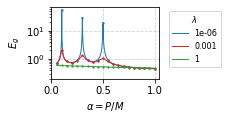

In [19]:
fig, ax = plt.subplots()
for lamInd, lam in enumerate(lams):
        curcolor  = getLamColor(lam)
#         if lam==0:
#             ax.errorbar(num_samples_list/M, test_err[:,lamInd,:].mean(1), test_err[:,lamInd,:].std(1)/np.sqrt(test_err.shape[-1]), marker = '*', markersize = 3, ls = '', color = curcolor)
#             ax.plot(alphas_theory, AllTotErrors[lamInd],  color = curcolor, label =str(lam), lw = 2, ls = '--')
#         else:

        #if lamInd>0:
        ax.errorbar(num_samples_list/M, test_err[:,lamInd,:].mean(1), test_err[:,lamInd,:].std(1)/np.sqrt(test_err.shape[-1]), marker = '.', markersize = 2.5, ls = '', color = curcolor)
        ax.plot(alphas_theory, AllTotErrors[lamInd],  color = curcolor, label =str(lam), lw=1)

        ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid
        ax.set_ylabel(r'$E_g$')
        ax.set_xlabel(r'$\alpha = P/M$')
        #ax.set_title(r'$\lambda$ = ' + str(lam) )

        ax.set_xlim([0, ax.get_xlim()[1]])
        ax.set_yscale('log')
        ax.set_ylim([.2,7*10**1])
        ax.set_xticks([0, .5, 1])

        
        #ax.legend(custom_lines, ['Shift = ' + str(shift) for shift in shift_list] + ['K = '+str(K) for K in KVals], bbox_to_anchor = (1.9, 1), loc = 'upper right')
        ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', title = r'$\lambda$')

        #fig = plt.gcf()
        set_size(1.5,1)
        fig.savefig('test_err_plot_TripleGlobCorr.svg', bbox_inches='tight', dpi = 300)
        #fig.tight_layout()